<a href="https://colab.research.google.com/github/titika2013/Speech_pro/blob/main/asr_labs/asr_lab_3_Grigoryan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика №3

Теперь в качестве акустической модели мы будем использовать простой DNN классификатор. На каждом кадре записи мы будем подавать его вектор признаков на DNN, которая будет выдавать "распределение вероятностей" по фонемам. Далее это распределение мы будем использовать в нашем алгоритме распознавания по словарю. Схема работы такого классификатора представлена ниже: 

![](https://drive.google.com/uc?export=view&id=1dv0VuE8DIoKXETbvnZq2PMixkWMCJOxr)

### Bootstrap

In [ ]:
!pip install --upgrade --no-cache-dir gdown

!gdown --id '1meikF0XqBUnVZKoY3160MQ0R25lq-EMu'
!gdown --id '1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox'

!unzip -q lab2.zip
!unzip -q train_librispeech_10h.zip
!mv lab2 lab3
!mv train_librispeech_10h lab3/data
!rm -rf lab2.zip sample_data train_librispeech_10h.zip
%cd lab3

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1meikF0XqBUnVZKoY3160MQ0R25lq-EMu
To: /content/lab2.zip
100% 1.66M/1.66M [00:00<00:00, 60.2MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1f0LkW6I3Q5CnOThuNFAJ9umgnb2eU4Ox
To: /content/train_librispeech_10h.zip
100% 679M/679M [00:03<00:00, 214MB/s]
/content/lab3


In [ ]:
import os
import numpy as np
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
import torch
import torch.nn as nn
import torch.functional as F


%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
# загрузка списка допустимых фонем:
def load_phones_dict(phones_file):
    phones_dict = {}
    with open(phones_file, encoding='utf-8') as fn:
        for index, line in enumerate(fn):
            phones_dict[line.strip()] = index
    return phones_dict

# загрузка покадровой фонемной разметки в словарь:
def load_phone_aligment(aligment_file):
    ali_dict = {}
    with open(aligment_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            ali_dict[line[0]] = line[1:]
    return ali_dict

# подсчет акустиеских признаков для записей из папки:
def load_data_dict(dir_path, count=None):
    data_dict = {}
    step = 0
    for wav_name in tqdm(os.listdir(dir_path)):
        x, sr = librosa.load(os.path.join(dir_path, wav_name), sr=None) 
        mfcc = librosa.feature.mfcc(x,
                                    sr=sr,
                                    n_mfcc=13, 
                                    n_fft=int(sr * 0.025),
                                    hop_length=int(sr * 0.01))
        step += 1
        if count and step == count:
            print(f'Early stop at {step}th file..')
            break
        data_dict[wav_name.split('.')[0]] = mfcc.T  
    return data_dict


phones_file = 'data/train_librispeech_10h/phones'
phones_dict = load_phones_dict(phones_file)

ali_file = 'data/train_librispeech_10h/ali_phones.txt'
ali_dict = load_phone_aligment(ali_file)

train_records_dir = 'data/train_librispeech_10h/wav_dir'
feats_dict = load_data_dict(train_records_dir, count=1000)

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stop at 1000th file..


### Априорная вероятность:

![](https://drive.google.com/uc?export=view&id=1WhjclhXm2POYsCgvxp3iAIOvT9F_k8If)

http://data-science.wiki/images/Automatic_Speech_Recognition_RxtNVMXYTy.pdf

In [ ]:
# объединение кадров признаков с соответствующими им фонемам v2:
def combain_data(ali_dict, feats_dict, phones_dict, side_context=None):
    data_list = []
    priors_list = [0] * len(phones_dict)
    for file_name in feats_dict.keys():
        file_feats = feats_dict[file_name]
        if side_context:
            file_feats = rolling_window(file_feats, side_context)
        file_ali = ali_dict[file_name]
        for frame in range(min(len(file_feats), len(file_ali))):
            data_list.append(np.append(file_feats[frame], phones_dict[file_ali[frame]]))
            priors_list[phones_dict[file_ali[frame]]] += 1
    return data_list, np.array(priors_list)/sum(priors_list)

side_context = None
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

In [ ]:
class CommonDataSet():

    def __init__(self, data_list, device, valid_proportion=0.1):
        self.train = data_list[:int((1-valid_proportion)*len(data_list))]
        self.valid = data_list[int((1-valid_proportion)*len(data_list)):]
        self.device = device
        
    def num_batches(self, batch_size):
        return len(self.train)//batch_size        
        
    def next_batch(self, batch_size):
        for i in range(self.num_batches(batch_size)):
            batch_xs = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size, :-1], dtype=torch.float32)
            batch_ys = torch.tensor(self.train[i * batch_size:(i + 1) * batch_size,-1].ravel(), dtype=torch.int64)

            yield batch_xs.to(device), batch_ys.to(device)

In [ ]:
class MyNNet(torch.nn.Module):

    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        # params:
        ff_dim = 256

        self.ff_net = torch.nn.Sequential(
            nn.Linear(input_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, ff_dim),
            nn.ReLU(),
            nn.Linear(ff_dim, output_dim),
        )


    def forward(self, x):
        x = self.ff_net(x)
        return (x)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(10):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 2.1997


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.8741


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.7891


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.7353


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6966


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6669


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6429


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6230


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6060


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5914
Time is: 1 min 27 sec


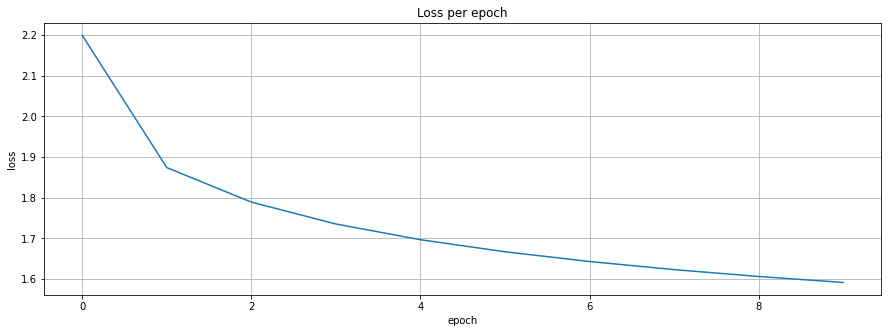

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.plot(loss_list)
plt.title('Loss per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()
plt.show()

In [ ]:
class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.531

SIL: 0.96 : 22193/23079
SPN: 0.01 : 5/708
AA0: 0.00 : 0/39
AA1: 0.36 : 636/1770
AA2: 0.00 : 0/92
AE0: 0.00 : 0/55
AE1: 0.54 : 1898/3486
AE2: 0.01 : 1/110
AH0: 0.36 : 1994/5550
AH1: 0.26 : 462/1764
AH2: 0.00 : 0/34
AO0: 0.00 : 0/25
AO1: 0.48 : 976/2021
AO2: 0.00 : 0/56
AW0: 0.00 : 0/13
AW1: 0.33 : 371/1118
AW2: 0.00 : 0/39
AY0: 0.00 : 0/36
AY1: 0.59 : 1806/3044
AY2: 0.00 : 0/155
B  : 0.31 : 482/1531
CH : 0.17 : 147/860
D  : 0.25 : 1003/4003
DH : 0.46 : 888/1922
EH0: 0.00 : 0/68
EH1: 0.26 : 748/2890
EH2: 0.00 : 0/90
ER0: 0.27 : 705/2612
ER1: 0.21 : 194/907
ER2: 0.00 : 0/15
EY0: 0.00 : 0/30
EY1: 0.59 : 1372/2325
EY2: 0.00 : 0/135
F  : 0.58 : 1358/2324
G  : 0.17 : 146/849
HH : 0.45 : 964/2154
IH0: 0.12 : 312/2580
IH1: 0.20 : 476/2322
IH2: 0.00 : 0/99
IY0: 0.33 : 730/2236
IY1: 0.47 : 1053/2229
IY2: 0.00 : 0/69
JH : 0.31 : 203/652
K  : 0.48 : 1476/3088
L  : 0.60 : 2424/4063
M  : 0.51 : 1563/3092
N  : 0.59 : 3515/5909
NG : 0.19 : 268/1385
OW0: 0.01 : 1/199
OW1: 

### Распознавание по словарю с помощью нейронной сети

In [ ]:
# теперь будем распознавать по словарю, состоящему из конечных слов
# для этого нужно загрузить файл лексикона, который определяет из каких фонем состоят наши слова
def load_lexicon_dict(lexicon_file):
    lexicon_dict = {}
    with open(lexicon_file, encoding='utf-8') as fn:
        for line in fn:
            line = line.strip().split()
            lexicon_dict[line[0]] = line[1:]
    return lexicon_dict

In [ ]:
class AcousticModel:
    def __init__(self, phone_name, phone_index, priors_list):
        self.phone_name = phone_name
        self.phone_index = phone_index
        self.phone_prior = priors_list[phone_index]
        
    def distance(self, input_feats, nnet):
        with torch.no_grad():
            predicts = nnet.forward(torch.tensor(input_feats, dtype=torch.float32))
            softmax = torch.nn.functional.softmax(predicts, dim=0)
        return -np.log(softmax[self.phone_index].item() / self.phone_prior)

class State:
    def __init__(self, model, index):  
        self.model = model                     # вектор признаков узла
        self.is_final = False                  # является ли этот узел финальнвм в слове
        self.word = None                       # слово эталона (назначается только для финального узла)
        self.best_token = None                 # лучший токен (по минимуму дистанции) в узле
        self.current_word = None               # текущее слово эталона
        self.next_states = []                  # список следующих узлов
        self.index = index                     # индекс узла 

        
def load_graph(lexicon_dict, phones_dict, priors_list):
    start_state = State(None, 0)
    graph = [start_state, ]
    state_index = 1
    for word in lexicon_dict.keys():
        previous_state = start_state
        for phone in lexicon_dict[word]:
            state = State(AcousticModel(phone, phones_dict[phone], priors_list), state_index)
            state.current_word = word           # слово эталона теперь будет храниться в каждом узле
            state.next_states.append(state)     # add loop
            previous_state.next_states.append(state)
            previous_state = state 
            graph.append(state)
            state_index += 1
        if state:
            state.word = word
            state.is_final = True
    return graph

In [ ]:
class Token:
    def __init__(self, state, dist=0.0, word=""):
        self.state = state       # стейт графа, в котором токен находится в текущий момент
        self.dist = dist         # общая накопленная дистанция пути, пройденного токеном
        self.word = word         # слово, которое распозналось токеном
        self.alive = True


def beam_pruning(next_tokens, threshold):   
    alive_tokens = [token for token in next_tokens if token.alive]
    best_token = alive_tokens[np.argmin([token.dist for token in alive_tokens if token.alive])]
    for token in next_tokens:
        if token.dist > best_token.dist + threshold:
            token.alive = False
    return next_tokens


def state_pruning(next_tokens):
    for i in range(len(next_tokens)): 
        state_index = next_tokens[i].state.index
        if not graph[state_index].best_token:
            graph[state_index].best_token = next_tokens[i]
        else:
            if next_tokens[i].dist <= graph[state_index].best_token.dist:
                graph[state_index].best_token.alive = False
                graph[state_index].best_token = next_tokens[i]
            else:
                next_tokens[i].alive = False
    for token in next_tokens:                           
        index = token.state.index                        
        if graph[index].best_token:                     
            graph[index].best_token = None              
    return next_tokens


def recognize(filename, features, graph, nnet, recognition_results, beam_threshold):

    start_state = graph[0]
    active_tokens = [Token(start_state), ]
    next_tokens = []
    
    for frame in range(len(features)):
        ftr_frame = features[frame]
        for token in active_tokens:
            if token.alive:
                for transition_state in token.state.next_states:
                    new_token = Token(transition_state, token.dist, token.word)
                    new_token.dist += transition_state.model.distance(ftr_frame, nnet)
                    next_tokens.append(new_token)
        # state and beam prunings:
        next_tokens = state_pruning(next_tokens)         
        next_tokens = beam_pruning(next_tokens, beam_threshold) 

        active_tokens = next_tokens
        next_tokens = []                                    
        
    # поиск финальных токенов:
    final_tokens = []
    for token in active_tokens:
        if token.state.is_final and token.alive:
            final_tokens.append(token)

    # если нет финальных, то берем лучший из выживших:
    if len(final_tokens) != 0:
        win_token = final_tokens[np.argmin([token.dist for token in final_tokens])]
    else:
        alive_tokens = [token for token in active_tokens if token.alive]
        win_token = alive_tokens[np.argmin([token.dist for token in alive_tokens])]
        win_token.state.word = win_token.state.current_word

    # вывод результата
    print(f"result: {filename:<27} ==> {win_token.state.word}")

    # совпадает ли запись с полученным эталоном:  
    record_word = filename.split('_')[0]
    etalon_word = win_token.state.word.split('_')[0]
    recognition_results.append(etalon_word.lower() == record_word)

    return recognition_results

In [ ]:
def run_recognizer(records_data_dict, graph, nnet, beam_threshold=10):
    start_time = time.time()
    recognition_results = []

    for filename in records_data_dict.keys():    
        recognition_results = recognize(filename,
                                        records_data_dict[filename],
                                        graph, nnet,
                                        recognition_results, beam_threshold)

    print("-" * 60)
    print(f"WER is: {(1 - sum(recognition_results)/len(recognition_results))*100:.2f}%")
    print(f"Total time is: {time.time() - start_time:.2f} sec")
    print("-" * 60)

### Запустим распознавание на базе YES_NO

In [ ]:
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> YES
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 10.00%
Total time is: 0.58 sec
------------------------------------------------------------


### Запустим распознавание на базе Digits

In [ ]:
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> SEVEN
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> SIX
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 20.00%
Total time is: 12.54 s

### <b>Задание №1</b> (5 баллов):
Реализовать контексты для входных признаков путем конкатенации кадров слева и справа от текущего. Не забудьте поддержать это и в функции распознавания. Насколько улучшилось качество на дата сетах?

![](https://drive.google.com/uc?export=view&id=1ft0z6CPhX20cJnA373uLoYwHPEagaKyo)

### **Ответ**:

In [ ]:
import functools
import operator


def rolling_window(feats, side_context):
  shape_res = (feats.shape[0], feats.shape[1] * (2*side_context + 1))
  concat_obj = np.zeros(shape_res)
  count = 0
  for i in range(side_context, len(feats) - side_context):
      tmp  = [feats[val] for val in range(i-side_context, i + side_context + 1)]
      tmp = functools.reduce(operator.iconcat, tmp, [])
      concat_obj [count]  = np.array(tmp)
      count += 1
  return concat_obj

In [ ]:
# возьмем side_context как на картинке
side_context = 2
data_list, priors_list = combain_data(ali_dict, feats_dict, phones_dict, side_context)
data_list = np.random.permutation(data_list)

Далее перезапускаю ячейки после combain_data и пересчитываю.

In [ ]:
# Yes No
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")


for key, val in records_data_dict.items():
  records_data_dict[key] = rolling_window(val, side_context)

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 0.55 sec
------------------------------------------------------------


Качество распознавания фонем Yes No улучшилось при увеличении контекста до 2 в среднем на 10  процентов.

In [ ]:
# digit
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

for key, val in records_data_dict.items():
  records_data_dict[key] = rolling_window(val, side_context)

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> FOUR
result: eight_daf230ac_nohash_0     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: one_fc2411fe_nohash_0       ==> NINE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 10.00%
Total time is: 11.54 s

Качество распознавания на digits улучшилось при увеличении контекста до 2 в среднем на 10 - 15 процентов.

### <b>Задание №2</b> (5 баллов):
Повысить качество классификации фонем за счет улучшения архитектуры нейронной сети, оптимизатора, расписания скорости обучения, других речевых признаков и т.п. Составить небольшой отчет на основе результатов перебора использованных способов. 

### **Ответ**:

In [ ]:
class MyNNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MyNNet, self).__init__()
        
        ff_dim = 256

        self.fl_1 = nn.Linear(input_dim, ff_dim )
        self.fl_2 = nn.Linear(ff_dim, ff_dim )
        self.fl_3 = nn.Linear(ff_dim, ff_dim)
        self.fl_4 = nn.Linear(ff_dim, ff_dim)
        self.fl_5 = nn.Linear(ff_dim, output_dim)
        
        
    def forward(self, x):
        x = torch.relu(self.fl_1(x))
        x = torch.relu(self.fl_2(x))
        x = torch.relu(self.fl_3(x))
        x = torch.relu(self.fl_4(x))
        x = self.fl_5(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load data:
data_set = CommonDataSet(data_list, device)

batch_size = 256

# training network model:
start = time.time() 
nnet = MyNNet(input_dim=(data_list[0].shape[0] - 1),
            output_dim=len(phones_dict.keys())).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.0001)

loss_list = []

print('TRAINIG STARTED...')
for epoch in range(15):
    running_loss = 0
    counter = 0
    for batch_xs, batch_ys in tqdm(data_set.next_batch(batch_size), \
                                   total=data_set.num_batches(batch_size), \
                                   desc='epoch {}'.format(epoch)):
        optimizer.zero_grad()
        output = nnet(batch_xs)

        loss = criterion(output, batch_ys)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        counter += 1
        
    print('loss is: {:.4f}'.format((running_loss / counter)))
    loss_list.append(running_loss / counter)
    
end = time.time()
minutes = (end - start) // 60
seconds = np.mod((end - start), 60)
print('Time is: {} min {} sec'.format(int(minutes), int(seconds)))

TRAINIG STARTED...


epoch 0:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.9716


epoch 1:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.7397


epoch 2:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6609


epoch 3:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.6111


epoch 4:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5739


epoch 5:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5442


epoch 6:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.5196


epoch 7:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4986


epoch 8:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4800


epoch 9:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4636


epoch 10:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4488


epoch 11:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4352


epoch 12:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4228


epoch 13:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4112


epoch 14:   0%|          | 0/4483 [00:00<?, ?it/s]

loss is: 1.4003
Time is: 2 min 59 sec


In [ ]:
from torch.autograd import Variable as V

class_correct = [0 for x in range(len(phones_dict.keys()))]
class_total = [0 for x in range(len(phones_dict.keys()))]

nnet.cpu()

with torch.no_grad():
    correct_cnt = 0
    for ftr, true_label in tqdm(zip(data_set.valid[:, :-1], data_set.valid[:, -1]), total=data_set.valid.shape[0]):
        ftr = torch.from_numpy(ftr).float()
        output = nnet.forward(ftr)
        #output = nnet(V(torch.Tensor(ftr[None,...])))
        predicted_label = output.argmax().item()
        correct_cnt += (predicted_label == true_label)
        class_correct[predicted_label] += (predicted_label == int(true_label))
        class_total[int(true_label)] += 1
        
print("Total frame accuracy is {:.3f}\n".format(correct_cnt / data_set.valid.shape[0]))

for idx, phone in enumerate(phones_dict.keys()):
    if class_total[idx]:
        print('{:3s}: {:.2f} : {}/{}'.format(phone, class_correct[idx] / class_total[idx], \
                                                     class_correct[idx], class_total[idx]))

  0%|          | 0/127534 [00:00<?, ?it/s]

Total frame accuracy is 0.562

SIL: 0.96 : 22270/23079
SPN: 0.03 : 18/708
AA0: 0.05 : 2/39
AA1: 0.35 : 617/1770
AA2: 0.00 : 0/92
AE0: 0.00 : 0/55
AE1: 0.58 : 2029/3486
AE2: 0.01 : 1/110
AH0: 0.40 : 2221/5550
AH1: 0.36 : 629/1764
AH2: 0.00 : 0/34
AO0: 0.00 : 0/25
AO1: 0.54 : 1082/2021
AO2: 0.00 : 0/56
AW0: 0.00 : 0/13
AW1: 0.36 : 401/1118
AW2: 0.00 : 0/39
AY0: 0.00 : 0/36
AY1: 0.61 : 1844/3044
AY2: 0.01 : 1/155
B  : 0.36 : 553/1531
CH : 0.24 : 207/860
D  : 0.29 : 1173/4003
DH : 0.51 : 973/1922
EH0: 0.09 : 6/68
EH1: 0.33 : 963/2890
EH2: 0.00 : 0/90
ER0: 0.26 : 678/2612
ER1: 0.39 : 355/907
ER2: 0.00 : 0/15
EY0: 0.03 : 1/30
EY1: 0.65 : 1512/2325
EY2: 0.01 : 1/135
F  : 0.66 : 1524/2324
G  : 0.21 : 178/849
HH : 0.52 : 1118/2154
IH0: 0.16 : 404/2580
IH1: 0.29 : 667/2322
IH2: 0.00 : 0/99
IY0: 0.33 : 742/2236
IY1: 0.50 : 1108/2229
IY2: 0.01 : 1/69
JH : 0.37 : 240/652
K  : 0.53 : 1636/3088
L  : 0.63 : 2554/4063
M  : 0.47 : 1450/3092
N  : 0.63 : 3747/5909
NG : 0.24 : 328/1385
OW0: 0.03 : 6/199
OW

In [ ]:
# Yes No
lexicon_file = 'data/lexicon_yes_no.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/yes_no/records")


for key, val in records_data_dict.items():
  records_data_dict[key] = rolling_window(val, side_context)

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=10)

  0%|          | 0/10 [00:00<?, ?it/s]

result: yes_fc94edb0_nohash_0       ==> YES
result: yes_ff63ab0b_nohash_0       ==> YES
result: yes_fe1916ba_nohash_0       ==> YES
result: no_41474817_nohash_0        ==> NO
result: no_49af4432_nohash_0        ==> NO
result: no_ad89eb1e_nohash_0        ==> NO
result: yes_39a12648_nohash_0       ==> YES
result: no_4394fc7c_nohash_0        ==> NO
result: no_4abb2400_nohash_0        ==> NO
result: yes_39a6b995_nohash_0       ==> YES
------------------------------------------------------------
WER is: 0.00%
Total time is: 0.78 sec
------------------------------------------------------------


In [ ]:
# digit
lexicon_file = 'data/lexicon_digits.txt'
lexicon_dict = load_lexicon_dict(lexicon_file)
graph = load_graph(lexicon_dict, phones_dict, priors_list)
records_data_dict = load_data_dict("data/digits/records")

for key, val in records_data_dict.items():
  records_data_dict[key] = rolling_window(val, side_context)

run_recognizer(records_data_dict, graph, nnet.cpu(), beam_threshold=100)

  0%|          | 0/20 [00:00<?, ?it/s]

result: three_feb1d305_nohash_0     ==> THREE
result: nine_fbe51750_nohash_0      ==> NINE
result: zero_f92e49f3_nohash_3      ==> ZERO
result: one_ffa76c4a_nohash_0       ==> ONE
result: eight_daf230ac_nohash_0     ==> EIGHT
result: nine_ccea893d_nohash_0      ==> NINE
result: two_fce65496_nohash_0       ==> TWO
result: one_fc2411fe_nohash_0       ==> ONE
result: four_ffbb695d_nohash_0      ==> FOUR
result: zero_f852895b_nohash_0      ==> ZERO
result: five_ffd2ba2f_nohash_0      ==> FIVE
result: five_f852895b_nohash_0      ==> FIVE
result: two_fb2f3242_nohash_0       ==> TWO
result: six_ffd2ba2f_nohash_0       ==> SIX
result: seven_fd32732a_nohash_0     ==> SEVEN
result: seven_fe5c4a7a_nohash_0     ==> SEVEN
result: six_ffbb695d_nohash_0       ==> SIX
result: four_fce65496_nohash_0      ==> FOUR
result: eight_da584bc0_nohash_4     ==> EIGHT
result: three_fce96bac_nohash_0     ==> THREE
------------------------------------------------------------
WER is: 0.00%
Total time is: 17.58 sec


- В первую очередь добавил слой в модель, что дало результат WER = 0 на yes_no и digits при side_context = 2 c Accuracy = 0.547. 
- При увеличении числа скрытых слоев и их размеров до 1300 давало Accuracy = 0.61 - 0.65,  но WER возрос до 10 процентов. 
- Дальнейшие эксперименты показали, что с ростом числа слоев и их размеров растет Accuracy, но начинает расти WER (наиболее вероятно это связнно связанно с переобучением, и малым размером контекста). 
- Подбирая гиперпараметры эмпирически (скорее всего кропотливо подбирая размер контекста и отслеживая параметры обучения, не давая модели переобучиться, можно получить хорошие результаты и на более объемных моделях), и думаю наиболее оптимально в данном задании добавить 1 или 2 слоя и получить WER=0.
